## Harmonize long-read and short-read AnnData objects for M132TS

This notebooks harmonizes long-read and short-read AnnData objects (e.g. mutual barcodes, mutual genes, etc.) and produces several AnnData outputs and figures, including a scrubbed AnnData object for Seurat SCT analysis.

**Inputs and Outputs**
- Inputs:
  - `M132TS_immune.h5ad`: short-reads AnnData object (immune component)
  - `M132TS_MAS_15x_m64020e_210506_132139_gene_tx_expression_count_matrix_tx_gene_counts_adata.h5ad`: long-reads counts matrix (raw)
- Outputs:
  - harmonized long-reads and short-reads AnnData objects (raw counts, all genes)
  - harmonized long-reads and short-reads AnnData objects (raw counts, all genes, metadata and unstructured data removed [for Seurat SCT analysis])
  - harmonized long-reads and short-reads AnnData objects (raw counts, mutual genes)
  - short vs. long gene expression concordance
  - gene- and transcript- level saturation curves + fit

In [1]:
%matplotlib inline

import matplotlib.pylab as plt

import numpy as np
import pandas as pd
import os
import sys
from time import time
import logging
import pickle
from operator import itemgetter

import scanpy as sc

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

logger = logging.getLogger()
logger.setLevel(logging.INFO)
log_info = logger.warning

import warnings
warnings.filterwarnings("ignore")

sc.settings.set_figure_params(dpi=80, facecolor='white')

In [2]:
repo_root = '/home/jupyter/mb-ml-data-disk/MAS-seq-analysis'

short_h5_path = 'output/t-cell-vdj-cite-seq/M132TS_immune.h5ad'
long_tx_counts_h5_path = 'data/t-cell-vdj/long/quant/v4/M132TS_MAS_15x_m64020e_210506_132139_gene_tx_expression_count_matrix_tx_gene_counts_adata.h5ad'

# raw output (only harmonized in terms of keeping matching cell barcodes)
harmonized_long_adata_h5_path = os.path.join(
    repo_root, 'output/t-cell-vdj-cite-seq/M132TS_immune.v4.harmonized.long.stringtie.h5ad')
harmonized_short_adata_h5_path = os.path.join(
    repo_root, 'output/t-cell-vdj-cite-seq/M132TS_immune.v4.harmonized.short.stringtie.h5ad')

# additionally, only mutual genes are retained
harmonized_long_adata_mutual_genes_h5_path = os.path.join(
    repo_root, 'output/t-cell-vdj-cite-seq/M132TS_immune.v4.harmonized.long.stringtie.mutual_genes.h5ad')
harmonized_short_adata_mutual_genes_h5_path = os.path.join(
    repo_root, 'output/t-cell-vdj-cite-seq/M132TS_immune.v4.harmonized.short.stringtie.mutual_genes.h5ad')

# this output is to be consumed by Seurat to generate SCT scaled data
# - most metadata is removed
harmonized_long_adata_seurat_input_h5_path = os.path.join(
    repo_root, 'output/t-cell-vdj-cite-seq/M132TS_immune.v4.harmonized.long.stringtie.seurat_input.h5ad')
harmonized_short_adata_seurat_input_h5_path = os.path.join(
    repo_root, 'output/t-cell-vdj-cite-seq/M132TS_immune.v4.harmonized.short.stringtie.seurat_input.h5ad')

In [3]:
adata_short = sc.read(os.path.join(repo_root, short_h5_path)).raw.to_adata()

In [4]:
adata_long = sc.read(os.path.join(repo_root, long_tx_counts_h5_path))
adata_long.var_names_make_unique()
adata_long.obs = adata_long.obs.drop('Cell Barcode', axis=1)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [5]:
adata_short

AnnData object with n_obs × n_vars = 6332 × 16200
    obs: 'CD45_TotalSeqC', 'CD45R_B220_TotalSeqC', 'CD45RA_TotalSeqC', 'CD45RO_TotalSeqC', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'antibody_feature', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne'

In [6]:
adata_long

AnnData object with n_obs × n_vars = 979261 × 199246
    var: 'transcript_ids', 'gene_ids', 'gene_names', 'transcript_names', 'de_novo_gene_ids', 'de_novo_transcript_ids', 'is_de_novo', 'is_gene_id_ambiguous', 'is_tcr_overlapping', 'gencode_overlap_gene_names', 'gencode_overlap_gene_ids', 'is_gencode_gene_overlap_ambiguous'

In [7]:
long_total_reads = 33_000_000
long_total_umis = adata_long.X.sum()
long_reads_per_umi = long_total_reads / long_total_umis 

In [8]:
print(f'Number of UMIs per read (long-read dataset): {long_reads_per_umi:.3f}')

Number of UMIs per read (long-read dataset): 1.379


In [9]:
adata_long.var

,transcript_ids,gene_ids,gene_names,transcript_names,de_novo_gene_ids,de_novo_transcript_ids,is_de_novo,is_gene_id_ambiguous,is_tcr_overlapping,gencode_overlap_gene_names,gencode_overlap_gene_ids,is_gencode_gene_overlap_ambiguous
ENST00000378466.9,ENST00000378466.9,ENSG00000157881.16,PANK4,STRG.1.1,STRG.1,STRG.1.1,False,False,False,PANK4,ENSG00000157881.16,False
STRG.1.2,STRG.1.2,ENSG00000157881.16,PANK4,STRG.1.2,STRG.1,STRG.1.2,True,False,False,PANK4,ENSG00000157881.16,False
STRG.1.3,STRG.1.3,ENSG00000157881.16,PANK4,STRG.1.3,STRG.1,STRG.1.3,True,False,False,PANK4,ENSG00000157881.16,False
STRG.1.4,STRG.1.4,ENSG00000157881.16,PANK4,STRG.1.4,STRG.1,STRG.1.4,True,False,False,PANK4,ENSG00000157881.16,False
STRG.10.1,STRG.10.1,STRG.10,STRG.10,STRG.10.1,STRG.10,STRG.10.1,True,False,False,AL139246.3,ENSG00000228037.1,False
...,...,...,...,...,...,...,...,...,...,...,...,...
STRG.99995.1,STRG.99995.1,STRG.99995,STRG.99995,STRG.99995.1,STRG.99995,STRG.99995.1,True,False,False,TRIM25,ENSG00000121060.18,False
STRG.99996.1,STRG.99996.1,STRG.99996,STRG.99996,STRG.99996.1,STRG.99996,STRG.99996.1,True,False,False,TRIM25,ENSG00000121060.18,False
ENST00000619432.1,ENST00000619432.1,ENSG00000274213.1,AC015912.3,STRG.99997.1,STRG.99997,STRG.99997.1,False,False,False,AC015912.3,ENSG00000274213.1,False
STRG.99998.1,STRG.99998.1,STRG.99998,STRG.99998,STRG.99998.1,STRG.99998,STRG.99998.1,True,False,False,STRG.99998,STRG.99998,False


In [10]:
ADATA_SHORT_GENE_IDS_COL = 'gene_ids'
ADATA_LONG_GENE_IDS_COL = 'gencode_overlap_gene_ids'

In [11]:
adata_long[:, adata_long.var['gencode_overlap_gene_names'] == 'PTPRC'].var

,transcript_ids,gene_ids,gene_names,transcript_names,de_novo_gene_ids,de_novo_transcript_ids,is_de_novo,is_gene_id_ambiguous,is_tcr_overlapping,gencode_overlap_gene_names,gencode_overlap_gene_ids,is_gencode_gene_overlap_ambiguous
STRG.8581.1,STRG.8581.1,ENSG00000081237.20,PTPRC,STRG.8581.1,STRG.8581,STRG.8581.1,True,False,False,PTPRC,ENSG00000081237.20,False
STRG.8581.10,STRG.8581.10,ENSG00000081237.20,PTPRC,STRG.8581.10,STRG.8581,STRG.8581.10,True,False,False,PTPRC,ENSG00000081237.20,False
STRG.8581.11,STRG.8581.11,ENSG00000081237.20,PTPRC,STRG.8581.11,STRG.8581,STRG.8581.11,True,False,False,PTPRC,ENSG00000081237.20,False
STRG.8581.12,STRG.8581.12,ENSG00000081237.20,PTPRC,STRG.8581.12,STRG.8581,STRG.8581.12,True,False,False,PTPRC,ENSG00000081237.20,False
STRG.8581.13,STRG.8581.13,ENSG00000081237.20,PTPRC,STRG.8581.13,STRG.8581,STRG.8581.13,True,False,False,PTPRC,ENSG00000081237.20,False
STRG.8581.14,STRG.8581.14,ENSG00000081237.20,PTPRC,STRG.8581.14,STRG.8581,STRG.8581.14,True,False,False,PTPRC,ENSG00000081237.20,False
ENST00000491302.1,ENST00000491302.1,ENSG00000081237.20,PTPRC,STRG.8581.15,STRG.8581,STRG.8581.15,False,False,False,PTPRC,ENSG00000081237.20,False
STRG.8581.16,STRG.8581.16,ENSG00000081237.20,PTPRC,STRG.8581.16,STRG.8581,STRG.8581.16,True,False,False,PTPRC,ENSG00000081237.20,False
STRG.8581.2,STRG.8581.2,ENSG00000081237.20,PTPRC,STRG.8581.2,STRG.8581,STRG.8581.2,True,False,False,PTPRC,ENSG00000081237.20,False
STRG.8581.3,STRG.8581.3,ENSG00000081237.20,PTPRC,STRG.8581.3,STRG.8581,STRG.8581.3,True,False,False,PTPRC,ENSG00000081237.20,False


## Align long adata to short adata

In [12]:
adata_gene_info_set = set(zip(
    adata_long.var[ADATA_LONG_GENE_IDS_COL].values,
    adata_long.var['is_de_novo'].values,
    adata_long.var['is_gene_id_ambiguous'].values))

gene_ids_set = set(map(itemgetter(0), adata_gene_info_set))
n_total_genes = len(gene_ids_set)
n_de_novo_genes = sum(map(lambda gene_id: gene_id.find('STRG') == 0, gene_ids_set))
n_gencode_genes = sum(map(lambda gene_id: gene_id.find('ENS') == 0, gene_ids_set))

print(f'all long adata genes: {n_total_genes}')
print(f'gencode long adata genes: {n_gencode_genes}')
print(f'de novo long adata genes: {n_de_novo_genes}')

all long adata genes: 37699
gencode long adata genes: 21088
de novo long adata genes: 16611


In [13]:
from collections import Counter

adata_short_gene_id_set = set(adata_short.var[ADATA_SHORT_GENE_IDS_COL].values)
adata_long_gene_id_set = set(adata_long.var[ADATA_LONG_GENE_IDS_COL].values)

# drop gencode version suffix ...
drop_version = lambda entry: entry.split('.')[0] if entry.find('ENS') == 0 else entry

unversioned_adata_short_gene_id_counter = Counter([
    drop_version(entry) for entry in adata_short_gene_id_set])
unversioned_adata_long_gene_id_counter = Counter([
    drop_version(entry) for entry in adata_long_gene_id_set])

ver_unambiguous_adata_short_gene_id_list = [
    gene_id for gene_id in unversioned_adata_short_gene_id_counter.keys()
    if unversioned_adata_short_gene_id_counter[gene_id] == 1]
ver_unambiguous_adata_long_gene_id_list = [
    gene_id for gene_id in unversioned_adata_long_gene_id_counter.keys()
    if unversioned_adata_long_gene_id_counter[gene_id] == 1]

gene_id_ambiguous_adata_long_unversioned_gene_id_set = set(map(
    drop_version,
    adata_long[:, adata_long.var['is_gene_id_ambiguous']].var[ADATA_LONG_GENE_IDS_COL].values))

gencode_gene_overlap_ambiguous_adata_long_unversioned_gene_id_set = set(map(
    drop_version,
    adata_long[:, adata_long.var['is_gencode_gene_overlap_ambiguous']].var[ADATA_LONG_GENE_IDS_COL].values))

final_unversioned_unambiguous_mutual_gene_id_set = \
    set(ver_unambiguous_adata_long_gene_id_list) \
    .intersection(ver_unambiguous_adata_short_gene_id_list) \
    .difference(gene_id_ambiguous_adata_long_unversioned_gene_id_set) \
#     .difference(gencode_gene_overlap_ambiguous_adata_long_unversioned_gene_id_set)

print(f'adata_short_gene_id_set: {len(adata_short_gene_id_set)}')
print(f'adata_long_gene_id_set: {len(adata_long_gene_id_set)}')
print(f'ver_unambiguous_adata_short_gene_id_list: {len(ver_unambiguous_adata_short_gene_id_list)}')
print(f'ver_unambiguous_adata_long_gene_id_list: {len(ver_unambiguous_adata_long_gene_id_list)}')
print(f'gene_id_ambiguous_adata_long_unversioned_gene_id_set: {len(gene_id_ambiguous_adata_long_unversioned_gene_id_set)}')
print(f'gencode_gene_overlap_ambiguous_adata_long_unversioned_gene_id_set: {len(gencode_gene_overlap_ambiguous_adata_long_unversioned_gene_id_set)}')
print(f'final_unversioned_unambiguous_mutual_gene_id_set: {len(final_unversioned_unambiguous_mutual_gene_id_set)}')

adata_short_gene_id_set: 16200
adata_long_gene_id_set: 37699
ver_unambiguous_adata_short_gene_id_list: 16200
ver_unambiguous_adata_long_gene_id_list: 37699
gene_id_ambiguous_adata_long_unversioned_gene_id_set: 594
gencode_gene_overlap_ambiguous_adata_long_unversioned_gene_id_set: 8280
final_unversioned_unambiguous_mutual_gene_id_set: 13583


In [14]:
final_adata_short_mutual_keep_var_indices = [
    var_idx
    for var_idx, gene_id in enumerate(adata_short.var[ADATA_SHORT_GENE_IDS_COL])
    if drop_version(gene_id) in final_unversioned_unambiguous_mutual_gene_id_set]

final_adata_long_mutual_keep_var_indices = [
    var_idx
    for var_idx, gene_id in enumerate(adata_long.var[ADATA_LONG_GENE_IDS_COL])
    if drop_version(gene_id) in final_unversioned_unambiguous_mutual_gene_id_set]

# sort both by gene_ids
final_adata_short_mutual_keep_var_indices = sorted(
    final_adata_short_mutual_keep_var_indices,
    key=lambda idx: drop_version(adata_short.var[ADATA_SHORT_GENE_IDS_COL].values[idx]))

final_adata_long_mutual_keep_var_indices = sorted(
    final_adata_long_mutual_keep_var_indices,
    key=lambda idx: drop_version(adata_long.var[ADATA_LONG_GENE_IDS_COL].values[idx]))

In [15]:
# subset long adata barcodes to short adata
adata_short_barcodes_set = set(adata_short.obs.index.values)
adata_long_keep_indices = []
found_barcodes_set = set()
for idx, bc in enumerate(adata_long.obs.index.values):
    if bc in adata_short_barcodes_set:
        adata_long_keep_indices.append(idx)
        found_barcodes_set.add(bc)
not_found_barcodes_set = adata_short_barcodes_set.difference(found_barcodes_set)

if len(not_found_barcodes_set) > 0:
    print(f'{len(not_found_barcodes_set)} out of {len(adata_short_barcodes_set)} could not be found in the long reads adata!')
else:
    print(f'All {len(adata_short_barcodes_set)} barcodes could be found in the long reads adata.')

found_barcodes_list = sorted(list(found_barcodes_set))

adata_short_barcode_index_map = {
    bc: idx for idx, bc in enumerate(adata_short.obs.index.values)}
final_adata_short_keep_obs_indices = [
    adata_short_barcode_index_map[barcode]
    for barcode in found_barcodes_list]

adata_long_barcode_index_map = {
    bc: idx for idx, bc in enumerate(adata_long.obs.index.values)}
final_adata_long_keep_obs_indices = [
    adata_long_barcode_index_map[barcode]
    for barcode in found_barcodes_list]

72 out of 6332 could not be found in the long reads adata!


In [16]:
# finally, slice
adata_short = adata_short[final_adata_short_keep_obs_indices]
adata_short_mutual = adata_short[:, final_adata_short_mutual_keep_var_indices]
adata_long = adata_long[final_adata_long_keep_obs_indices]
adata_long_mutual = adata_long[:, final_adata_long_mutual_keep_var_indices]

In [17]:
adata_short

View of AnnData object with n_obs × n_vars = 6260 × 16200
    obs: 'CD45_TotalSeqC', 'CD45R_B220_TotalSeqC', 'CD45RA_TotalSeqC', 'CD45RO_TotalSeqC', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'antibody_feature', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne'

In [18]:
adata_long

View of AnnData object with n_obs × n_vars = 6260 × 199246
    var: 'transcript_ids', 'gene_ids', 'gene_names', 'transcript_names', 'de_novo_gene_ids', 'de_novo_transcript_ids', 'is_de_novo', 'is_gene_id_ambiguous', 'is_tcr_overlapping', 'gencode_overlap_gene_names', 'gencode_overlap_gene_ids', 'is_gencode_gene_overlap_ambiguous'

In [19]:
adata_short_mutual

View of AnnData object with n_obs × n_vars = 6260 × 13583
    obs: 'CD45_TotalSeqC', 'CD45R_B220_TotalSeqC', 'CD45RA_TotalSeqC', 'CD45RO_TotalSeqC', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'antibody_feature', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne'

In [20]:
adata_long_mutual

View of AnnData object with n_obs × n_vars = 6260 × 146101
    var: 'transcript_ids', 'gene_ids', 'gene_names', 'transcript_names', 'de_novo_gene_ids', 'de_novo_transcript_ids', 'is_de_novo', 'is_gene_id_ambiguous', 'is_tcr_overlapping', 'gencode_overlap_gene_names', 'gencode_overlap_gene_ids', 'is_gencode_gene_overlap_ambiguous'

In [21]:
adata_short.obs.head()

,CD45_TotalSeqC,CD45R_B220_TotalSeqC,CD45RA_TotalSeqC,CD45RO_TotalSeqC,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,leiden
AAACCTGAGCAGGTCA,6.918695,3.713572,3.401197,3.637586,828,2391.0,178.0,7.444583,1
AAACCTGAGTACGCCC,6.949856,3.713572,4.189655,3.871201,1137,3113.0,226.0,7.259878,8
AAACCTGCAAGCCCAC,7.470224,4.499810,3.737670,5.313206,1124,3095.0,137.0,4.426494,3
AAACCTGCAGCGAACA,7.848544,4.477337,6.008813,5.493062,1427,5239.0,277.0,5.287268,3
AAACCTGCATATGCTG,8.039158,4.317488,3.433987,5.686975,2110,7248.0,400.0,5.518764,4


In [22]:
adata_long.obs.head()

""
AAACCTGAGCAGGTCA
AAACCTGAGTACGCCC
AAACCTGCAAGCCCAC
AAACCTGCAGCGAACA
AAACCTGCATATGCTG


In [23]:
adata_short.var

,gene_ids,feature_types,genome,mt,antibody_feature,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells
LINC01409,ENSG00000237491,Gene Expression,GRCh38,False,False,334,0.054643,94.725205,346.0,334
LINC01128,ENSG00000228794,Gene Expression,GRCh38,False,False,211,0.034428,96.667720,218.0,211
LINC00115,ENSG00000225880,Gene Expression,GRCh38,False,False,36,0.005685,99.431459,36.0,36
FAM41C,ENSG00000230368,Gene Expression,GRCh38,False,False,23,0.003632,99.636766,23.0,23
NOC2L,ENSG00000188976,Gene Expression,GRCh38,False,False,635,0.116077,89.971573,735.0,635
...,...,...,...,...,...,...,...,...,...,...
AC011043.1,ENSG00000276256,Gene Expression,GRCh38,False,False,14,0.002211,99.778901,14.0,14
AL354822.1,ENSG00000278384,Gene Expression,GRCh38,False,False,13,0.002053,99.794694,13.0,13
AL592183.1,ENSG00000273748,Gene Expression,GRCh38,False,False,28,0.004422,99.557802,28.0,28
AC240274.1,ENSG00000271254,Gene Expression,GRCh38,False,False,9,0.001421,99.857865,9.0,9


In [24]:
adata_long.var

,transcript_ids,gene_ids,gene_names,transcript_names,de_novo_gene_ids,de_novo_transcript_ids,is_de_novo,is_gene_id_ambiguous,is_tcr_overlapping,gencode_overlap_gene_names,gencode_overlap_gene_ids,is_gencode_gene_overlap_ambiguous
ENST00000378466.9,ENST00000378466.9,ENSG00000157881.16,PANK4,STRG.1.1,STRG.1,STRG.1.1,False,False,False,PANK4,ENSG00000157881.16,False
STRG.1.2,STRG.1.2,ENSG00000157881.16,PANK4,STRG.1.2,STRG.1,STRG.1.2,True,False,False,PANK4,ENSG00000157881.16,False
STRG.1.3,STRG.1.3,ENSG00000157881.16,PANK4,STRG.1.3,STRG.1,STRG.1.3,True,False,False,PANK4,ENSG00000157881.16,False
STRG.1.4,STRG.1.4,ENSG00000157881.16,PANK4,STRG.1.4,STRG.1,STRG.1.4,True,False,False,PANK4,ENSG00000157881.16,False
STRG.10.1,STRG.10.1,STRG.10,STRG.10,STRG.10.1,STRG.10,STRG.10.1,True,False,False,AL139246.3,ENSG00000228037.1,False
...,...,...,...,...,...,...,...,...,...,...,...,...
STRG.99995.1,STRG.99995.1,STRG.99995,STRG.99995,STRG.99995.1,STRG.99995,STRG.99995.1,True,False,False,TRIM25,ENSG00000121060.18,False
STRG.99996.1,STRG.99996.1,STRG.99996,STRG.99996,STRG.99996.1,STRG.99996,STRG.99996.1,True,False,False,TRIM25,ENSG00000121060.18,False
ENST00000619432.1,ENST00000619432.1,ENSG00000274213.1,AC015912.3,STRG.99997.1,STRG.99997,STRG.99997.1,False,False,False,AC015912.3,ENSG00000274213.1,False
STRG.99998.1,STRG.99998.1,STRG.99998,STRG.99998,STRG.99998.1,STRG.99998,STRG.99998.1,True,False,False,STRG.99998,STRG.99998,False


In [25]:
# propagate some columns from short to long
adata_short_obs_col_propagate = ['CD45_TotalSeqC', 'CD45R_B220_TotalSeqC', 'CD45RA_TotalSeqC', 'CD45RO_TotalSeqC']
adata_short_obsm_col_propagate = ['X_pca', 'X_tsne']

for col in adata_short_obs_col_propagate:
    try:
        adata_long.obs[col] = adata_short.obs[col].values.copy()
        adata_long_mutual.obs[col] = adata_short.obs[col].values.copy()
    except:
        log_info(f'WARNING: Could not propagate {col}!')
    
for col in adata_short_obsm_col_propagate:
    try:
        adata_long.obsm[col] = adata_short.obsm[col].copy()
        adata_long_mutual.obsm[col] = adata_short.obsm[col].copy()
    except:
        log_info(f'WARNING: Could not propagate {col}!')

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [26]:
adata_long_stripped = adata_long.copy()
adata_long_stripped.obs = adata_long_stripped.obs.drop(list(adata_long.obs.columns), axis=1)
adata_long_stripped.obsm.clear()

adata_short_stripped = adata_short.copy()
adata_short_stripped.obs = adata_short_stripped.obs.drop(list(adata_short.obs.columns), axis=1)
adata_short_stripped.var = adata_short_stripped.var.drop(list(adata_short.var.columns), axis=1)
adata_short_stripped.uns.clear()
adata_short_stripped.obsm.clear()
adata_short_stripped.varm.clear()
adata_short_stripped.obsp.clear()

In [27]:
# save
adata_long.write(harmonized_long_adata_h5_path)
adata_short.write(harmonized_short_adata_h5_path)
adata_long_mutual.write(harmonized_long_adata_mutual_genes_h5_path)
adata_short_mutual.write(harmonized_short_adata_mutual_genes_h5_path)
adata_long_stripped.write(harmonized_long_adata_seurat_input_h5_path)
adata_short_stripped.write(harmonized_short_adata_seurat_input_h5_path)

## Concordance between short and long adata total GEX over mutual genes

In [28]:
adata_short = sc.read(harmonized_short_adata_mutual_genes_h5_path)
adata_long = sc.read(harmonized_long_adata_mutual_genes_h5_path)

Only considering the two last: ['.mutual_genes', '.h5ad'].
Only considering the two last: ['.mutual_genes', '.h5ad'].
Only considering the two last: ['.mutual_genes', '.h5ad'].
Only considering the two last: ['.mutual_genes', '.h5ad'].


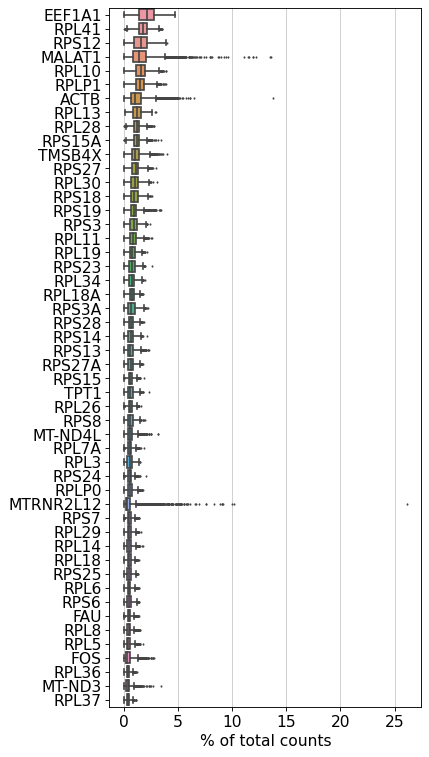

In [29]:
# highest expressed isoforms
sc.pl.highest_expr_genes(adata_short, n_top=50)

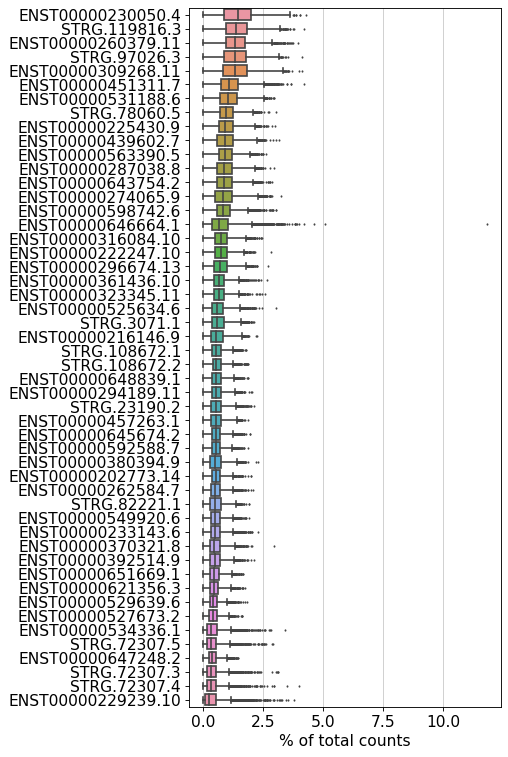

In [30]:
# highest expressed isoforms
sc.pl.highest_expr_genes(adata_long, n_top=50)

In [31]:
total_tx_expr_long = np.asarray(adata_long.X.sum(0)).flatten()
total_gene_expr_short = np.asarray(adata_short.X.sum(0)).flatten()

In [32]:
short_gene_ids = list(map(drop_version, adata_short.var[ADATA_SHORT_GENE_IDS_COL].values))
long_gene_ids = list(map(drop_version, adata_long.var[ADATA_LONG_GENE_IDS_COL].values))

In [33]:
from itertools import groupby
from operator import itemgetter

gene_id_to_tx_indices_map = dict()
for g in groupby(enumerate(long_gene_ids), key=itemgetter(1)):
    gene_id = g[0]
    tx_indices = list(map(itemgetter(0), g[1]))
    gene_id_to_tx_indices_map[gene_id] = tx_indices
    
total_gene_expr_long = []
for gene_id in short_gene_ids:
    total_gene_expr_long.append(np.sum(total_tx_expr_long[gene_id_to_tx_indices_map[gene_id]]))
total_gene_expr_long = np.asarray(total_gene_expr_long)

In [34]:
total_gene_expr_short_tpm = 1_000_000 * total_gene_expr_short / np.sum(total_gene_expr_short)
total_gene_expr_long_tpm = 1_000_000 * total_gene_expr_long / np.sum(total_gene_expr_long)

In [35]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

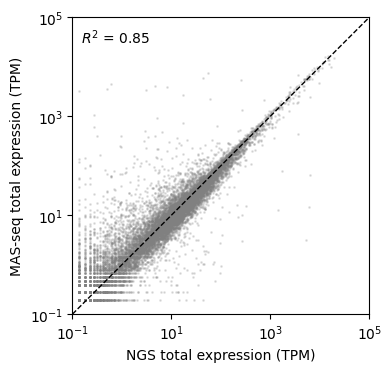

In [36]:
import matplotlib.ticker as tck
from sklearn.metrics import r2_score

fig, ax = plt.subplots(figsize=(4, 4))

ax.plot([1e-1, 1e5], [1e-1, 1e5], '--', lw=1, color='black')
ax.scatter(total_gene_expr_short_tpm, total_gene_expr_long_tpm, s=1, alpha=0.2, color='gray')
r2 = r2_score(np.log1p(total_gene_expr_short_tpm), np.log1p(total_gene_expr_long_tpm))
ax.text(0.15, 3e4, f'$R^2$ = {r2:.2f}', fontsize=10)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks([1e-1, 1e1, 1e3, 1e5])
ax.set_yticks([1e-1, 1e1, 1e3, 1e5])
ax.xaxis.set_minor_locator(tck.AutoMinorLocator())
ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
ax.set_xlim((1e-1, 1e5))
ax.set_ylim((1e-1, 1e5))
ax.set_aspect('equal')
# ax.set_title('M132TS')
ax.set_xlabel('NGS total expression (TPM)')
ax.set_ylabel('MAS-seq total expression (TPM)')

fig.tight_layout()

plt.savefig('./output/M132TS__short_long_gex_concordance.pdf')

## Cell-level and gene-level summary statistics

In [37]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [38]:
adata_short = sc.read(harmonized_short_adata_h5_path)
adata_long = sc.read(harmonized_long_adata_h5_path)

Only considering the two last: ['.stringtie', '.h5ad'].
Only considering the two last: ['.stringtie', '.h5ad'].
Only considering the two last: ['.stringtie', '.h5ad'].
Only considering the two last: ['.stringtie', '.h5ad'].


In [39]:
umis_per_cell_short = np.median(np.asarray(adata_short.X.sum(-1)).flatten())
print(f'Median UMIs per cell (short-reads dataset): {umis_per_cell_short}')

Median UMIs per cell (short-reads dataset): 3211.5


In [40]:
umis_per_cell_long = np.median(np.asarray(adata_long.X.sum(-1)).flatten())
print(f'Median UMIs per cell (long-reads dataset): {umis_per_cell_long}')

Median UMIs per cell (long-reads dataset): 1538.0


In [41]:
adata_short_umi_counts_n = np.asarray(adata_short.X.sum(-1)).flatten()
adata_short_unique_gene_counts_n = np.asarray((adata_short.X > 0).sum(-1)).flatten()

In [42]:
adata_long_umi_counts_n = np.asarray(adata_long.X.sum(-1)).flatten()
adata_long_unique_transcript_counts_n = np.asarray((adata_long.X > 0).sum(-1)).flatten()

In [43]:
import scipy

gid_set = set(adata_long.var[ADATA_LONG_GENE_IDS_COL].values)
gid_to_g_idx = {gid: g_idx for g_idx, gid in enumerate(gid_set)}

t_idx_list = []
g_idx_list = []
values = []
for t_idx, gid in enumerate(adata_long.var[ADATA_LONG_GENE_IDS_COL].values):
    t_idx_list.append(t_idx)
    g_idx_list.append(gid_to_g_idx[gid])
    values.append(1)
    
t_idx_to_g_idx_map = scipy.sparse.coo_matrix(
    (values, (t_idx_list, g_idx_list)),
    shape=[len(adata_long.var[ADATA_SHORT_GENE_IDS_COL].values), len(gid_set)])

adata_long_X_cg = adata_long.X @ t_idx_to_g_idx_map
adata_long_unique_gene_counts_n = np.asarray((adata_long_X_cg > 0).sum(-1)).flatten()

In [44]:
from scipy.optimize import curve_fit

def exp_saturation_curve(x, a1, a2, b1, b2):
    y = x / 10_000
    return 10_000 * (a1 * y + a2 * y**2) / (1 + b1 * y + b2 * y**2)

In [45]:
x_fit = np.linspace(0, 30_000, num=100)

umi_cutoff = 100

popt, pcov = curve_fit(
    exp_saturation_curve,
    adata_short_umi_counts_n[adata_short_umi_counts_n > umi_cutoff],
    adata_short_unique_gene_counts_n[adata_short_umi_counts_n > umi_cutoff], bounds=(0, 100.))

adata_short_unique_gene_counts_n_fit = exp_saturation_curve(x_fit, *tuple(popt))

popt, pcov = curve_fit(
    exp_saturation_curve,
    adata_long_umi_counts_n[adata_long_umi_counts_n > umi_cutoff],
    adata_long_unique_transcript_counts_n[adata_long_umi_counts_n > umi_cutoff], bounds=(0, 100.))

adata_long_unique_transcript_counts_n_fit = exp_saturation_curve(x_fit, *tuple(popt))

popt, pcov = curve_fit(
    exp_saturation_curve,
    adata_long_umi_counts_n[adata_long_umi_counts_n > umi_cutoff],
    adata_long_unique_gene_counts_n[adata_long_umi_counts_n > umi_cutoff], bounds=(0, 100.))

adata_long_unique_gene_counts_n_fit = exp_saturation_curve(x_fit, *tuple(popt))

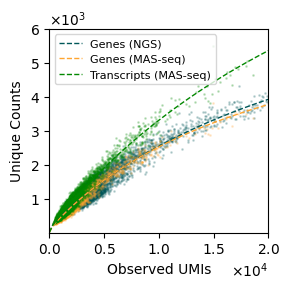

In [46]:
import colorcet as cc

fig, ax = plt.subplots(figsize=(3, 3))

alpha = 0.2
s = 1
lw = 1
adata_short_unique_gene_counts_color = list(cc.cm.glasbey(9)[:3])
adata_long_unique_gene_counts_color = list(cc.cm.glasbey(7)[:3])
adata_long_unique_transcript_counts_color = list(cc.cm.glasbey(2)[:3])

ax.scatter(adata_short_umi_counts_n, adata_short_unique_gene_counts_n, s=s, color=adata_short_unique_gene_counts_color + [alpha])
ax.scatter(adata_long_umi_counts_n, adata_long_unique_gene_counts_n, s=s, color=adata_long_unique_gene_counts_color + [alpha])
ax.scatter(adata_long_umi_counts_n, adata_long_unique_transcript_counts_n, s=s, color=adata_long_unique_transcript_counts_color + [alpha])

ax.plot(x_fit, adata_short_unique_gene_counts_n_fit, color=adata_short_unique_gene_counts_color, lw=lw, linestyle='--', label='Genes (NGS)')
ax.plot(x_fit, adata_long_unique_gene_counts_n_fit, color=adata_long_unique_gene_counts_color, lw=lw, linestyle='--', label='Genes (MAS-seq)')
ax.plot(x_fit, adata_long_unique_transcript_counts_n_fit, color=adata_long_unique_transcript_counts_color, lw=lw, linestyle='--', label='Transcripts (MAS-seq)')

ax.set_xlim((0, 2e4))
ax.set_ylim((1, 6e3))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,1), useMathText=True)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,1), useMathText=True)

ax.legend(fontsize=8)
ax.set_xlabel('Observed UMIs')
ax.set_ylabel('Unique Counts')

fig.tight_layout()

plt.savefig('./output/M132TS__saturation.pdf')